# VALIDATION DATASET = 10000:

REPLICAS:  1
1/1 [==============================] - 4s 4s/step
Shape of dummy_output directly after model definition: (1, 640, 480, 3)
Epoch 1/12


I0000 00:00:1706878434.983343     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - 334s 2s/step - loss: 0.1277 - SSIMLoss: 0.1277 - val_loss: 0.4139 - val_SSIMLoss: 0.4139
Epoch 2/12
125/125 [==============================] - 305s 2s/step - loss: 0.0762 - SSIMLoss: 0.0762 - val_loss: 0.2941 - val_SSIMLoss: 0.2941
Epoch 3/12
125/125 [==============================] - 304s 2s/step - loss: 0.0684 - SSIMLoss: 0.0684 - val_loss: 0.1717 - val_SSIMLoss: 0.1717
Epoch 4/12
125/125 [==============================] - 310s 2s/step - loss: 0.0643 - SSIMLoss: 0.0643 - val_loss: 0.0770 - val_SSIMLoss: 0.0770
Epoch 5/12
125/125 [==============================] - 306s 2s/step - loss: 0.0606 - SSIMLoss: 0.0606 - val_loss: 0.0383 - val_SSIMLoss: 0.0383
Epoch 6/12
125/125 [==============================] - 293s 2s/step - loss: 0.0590 - SSIMLoss: 0.0590 - val_loss: 0.0736 - val_SSIMLoss: 0.0736
Epoch 7/12
125/125 [==============================] - 293s 2s/step - loss: 0.0565 - SSIMLoss: 0.0565 - val_loss: 0.0540 - val_SSIMLoss: 0.0540
Epoch 8/12

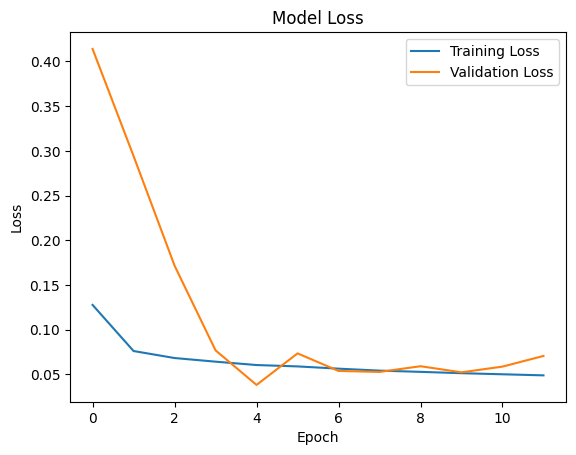

1/1 [==============================] - 0s 233ms/step - loss: 0.0623 - SSIMLoss: 0.0623
Test Loss: [0.062337279319763184, 0.062337279319763184]
1/1 [==============================] - 0s 42ms/step


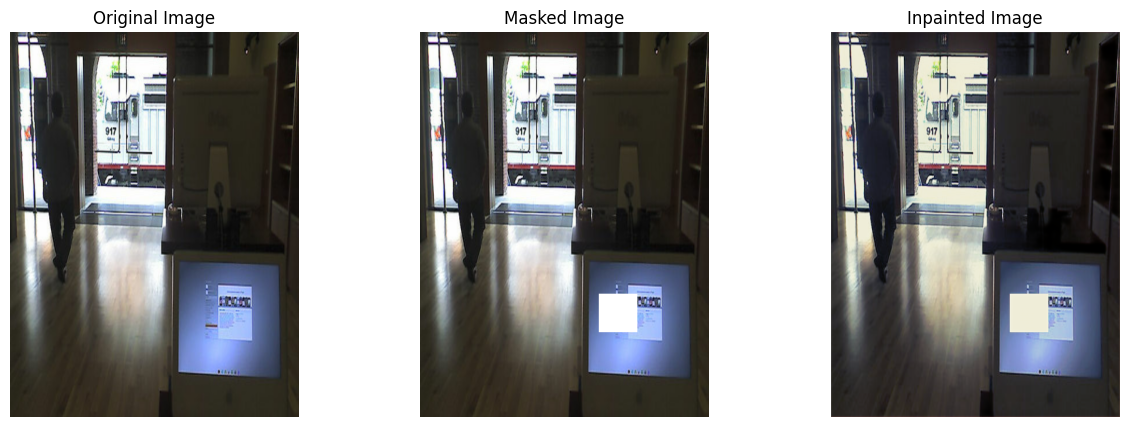

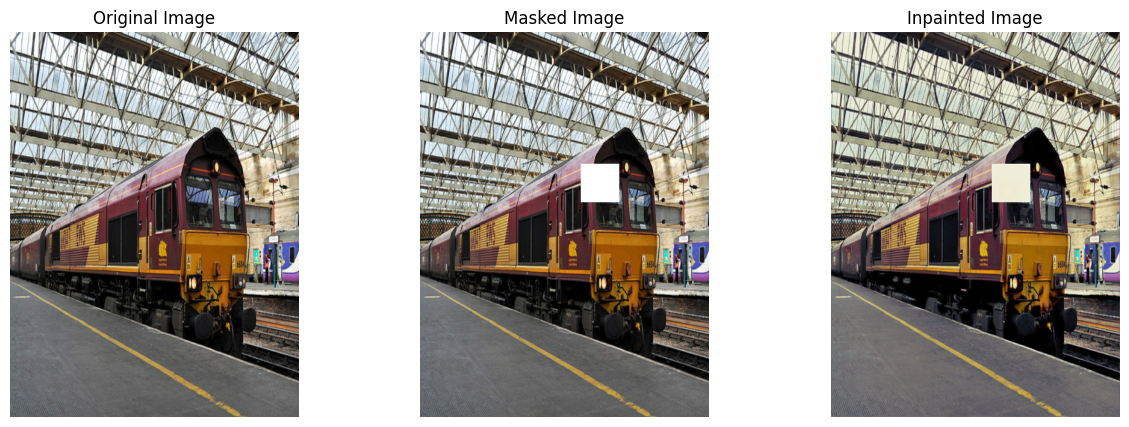

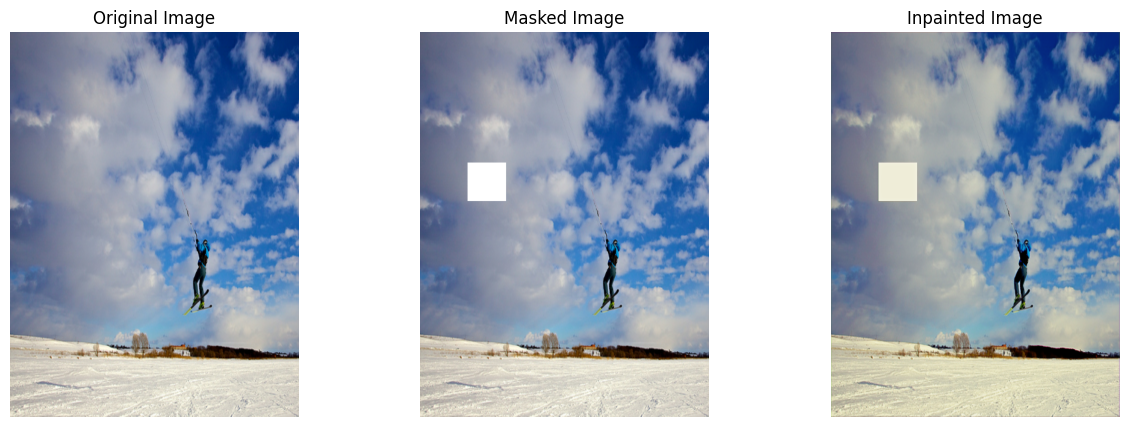

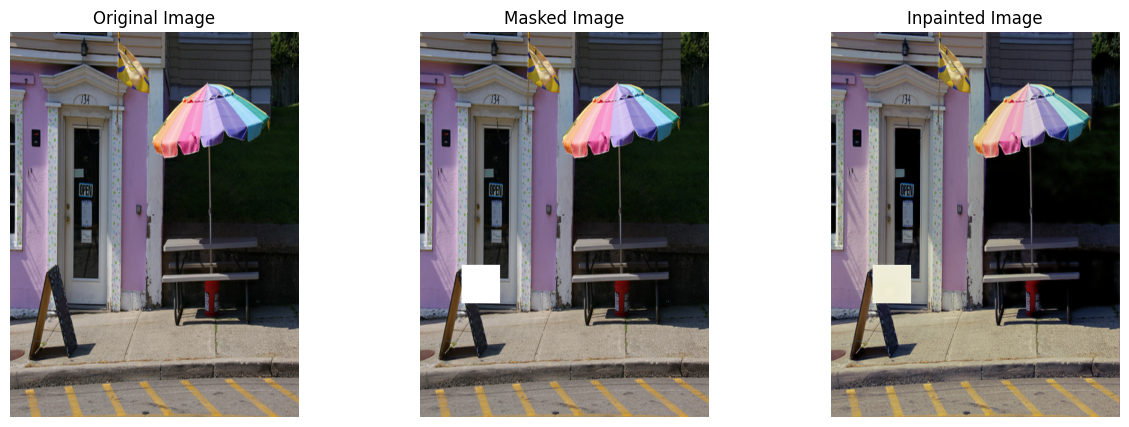

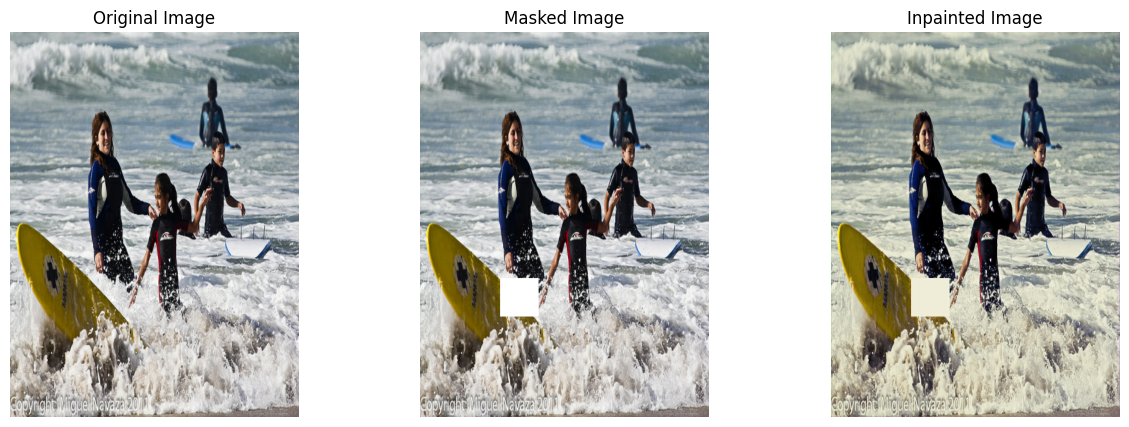

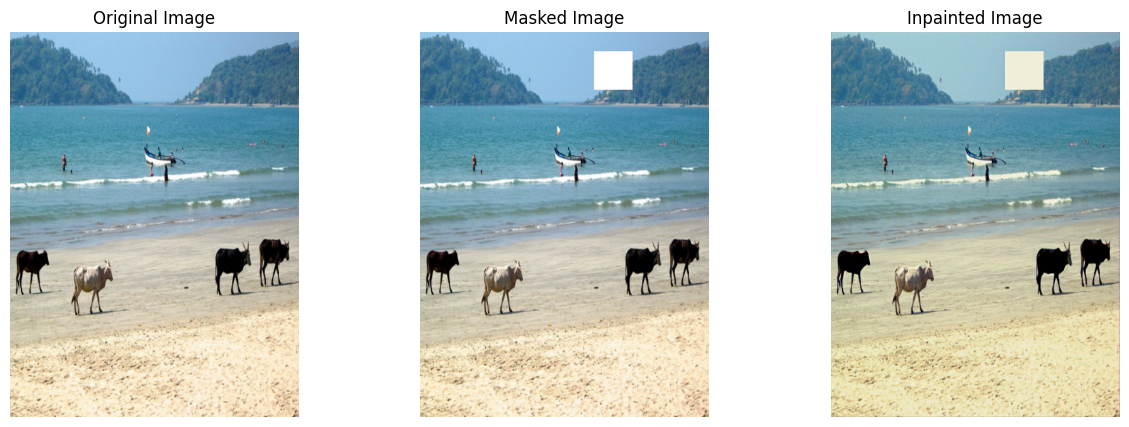

In [4]:
import os
import random
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np

from skimage import metrics


def conv_block(input_tensor, num_filters):
    """Function for a convolutional block with BatchNormalization and ReLU activation"""
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    """Function for the encoder block"""
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    """Function for the decoder block"""
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

def unet_complex(input_size):
    inputs = tf.keras.Input(shape=input_size)

    # Encoding path
    encoder0_pool, encoder0 = encoder_block(inputs, 32)
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
    encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)

    # Bottleneck
    center = conv_block(encoder4_pool, 1024)

    # Decoding path
    decoder4 = decoder_block(center, encoder4, 512)
    decoder3 = decoder_block(decoder4, encoder3, 256)
    decoder2 = decoder_block(decoder3, encoder2, 128)
    decoder1 = decoder_block(decoder2, encoder1, 64)
    decoder0 = decoder_block(decoder1, encoder0, 32)

    # Output layer
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(decoder0)  # Adjusted the output layer

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model



# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()  # default strategy that works on CPU and single GPU

print("REPLICAS: ", strategy.num_replicas_in_sync)

class InpaintingDataGenerator:
    def __init__(self, image_dir, batch_size, num_samples=None, mask_size=(64, 64), target_size=(256, 256)):
        self.image_dir = image_dir
        self.image_names = os.listdir(image_dir)
        self.batch_size = batch_size
        self.mask_size = mask_size
        self.target_size = target_size
        if num_samples is not None and num_samples < len(self.image_names):
            self.image_names = random.sample(self.image_names, num_samples)
        self.dataset = self.create_dataset()
    
    def create_dataset(self):
        # Create a dataset of file paths
        path_dataset = tf.data.Dataset.from_tensor_slices(self.image_names)

        # Map the file paths to images, masks, and masked images
        image_dataset = path_dataset.map(
            lambda x: self.load_and_preprocess_image(
                self.image_dir, tf.strings.split(x, os.sep)[-1]  # Pass directory and filename separately
            ), 
            num_parallel_calls=tf.data.AUTOTUNE
        )

        # Unpack the tuple into separate elements
        image_dataset = image_dataset.map(lambda x, y: (x, y))

        # Batch and prefetch
        image_dataset = image_dataset.batch(self.batch_size)
        image_dataset = image_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

        return image_dataset
    
    def load_and_preprocess_image(self, dir_path, filename):
        # Combine the directory and filename to get the full path to the image
        img_path = tf.strings.join([dir_path, filename], separator='/')
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, self.target_size)
        # Create mask
        img_size = tf.shape(img)[:2]
        mask = tf.zeros((img_size[0], img_size[1], 1), dtype=tf.float32)
        top_left_x = tf.random.uniform((), 0, img_size[0] - self.mask_size[0], dtype=tf.int32)
        top_left_y = tf.random.uniform((), 0, img_size[1] - self.mask_size[1], dtype=tf.int32)
        bottom_right_x = top_left_x + self.mask_size[0]
        bottom_right_y = top_left_y + self.mask_size[1]

        # Generate indices for the mask
        indices = tf.reshape(
            tf.stack(
                tf.meshgrid(
                    tf.range(top_left_x, bottom_right_x),
                    tf.range(top_left_y, bottom_right_y),
                    indexing='ij'
                ),
                axis=-1
            ),
            (-1, 2)
        )
    
        # Create updates for the mask
        updates = tf.ones((self.mask_size[0] * self.mask_size[1], 1), dtype=tf.float32)

        # Update the mask tensor
        mask = tf.tensor_scatter_nd_update(mask, indices, updates)

        # Apply mask
        masked_img = img * (1 - mask) + mask

        # Return a tuple of two elements:
        # 1. the masked image (input to the model)
        # 2. the original image (ground truth for training)
        return masked_img, img

# Define directory paths and batch size
train_image_dir = '/kaggle/input/coco2017/train2017'
val_image_dir = '/kaggle/input/coco2017/test2017'
test_image_dir = '/kaggle/input/coco2017/val2017'
batch_size = 8 * strategy.num_replicas_in_sync  # Adjust batch size based on the number of TPU cores


# Ensure that the validation set has at least 10,000 images
val_image_names = os.listdir(val_image_dir)
assert len(val_image_names) >= 10000, f"Validation dataset should have at least 10000 photos, got {len(val_image_names)}."

    
# Initialize data generators
train_generator = InpaintingDataGenerator(train_image_dir, batch_size, num_samples=1000, target_size=(640, 480))
val_generator = InpaintingDataGenerator(val_image_dir, batch_size, target_size=(640, 480), num_samples=10000)
test_generator = InpaintingDataGenerator(test_image_dir, batch_size, target_size=(640, 480), num_samples=1000)

# losses
# check also mae i msa
# save all of the models for comparison
def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303


# Initialize the complex U-Net model within the TPU strategy scope
with strategy.scope():
    final_model = unet_complex(input_size=(640, 480, 3))
    # It's crucial to compile the model within the strategy scope.
    final_model.compile(optimizer='rmsprop', loss=SSIMLoss, metrics=[SSIMLoss])

    # After compiling, make a dummy prediction to check the output shape.
    dummy_input = tf.random.normal((1, 640, 480, 3))
    dummy_output = final_model.predict(dummy_input)
    print("Shape of dummy_output directly after model definition:", dummy_output.shape)

# Initialize callbacks
callbacks = [
    ModelCheckpoint('best_inpainting_model.tf', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Train the model
history = final_model.fit(
    train_generator.dataset,
    epochs=12,  # Adjust as needed
    steps_per_epoch=min(1000, len(train_generator.image_names)) // batch_size,
    validation_data=val_generator.dataset,
    validation_steps=len(val_generator.image_names) // batch_size,  # Use all validation data
    callbacks=callbacks
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# # Evaluate on test set
# test_loss = final_model.evaluate(
#     test_generator.dataset,
#     steps=len(test_generator.image_names) // batch_size
# )


# Evaluate on test set
for sample in test_generator.dataset.take(1):
    masked_images, original_images = sample
    test_loss = final_model.evaluate(masked_images, original_images)
    print(f'Test Loss: {test_loss}')
    

# Display inpainting results
def display_inpainting_results(model, generator, num_samples=3):
    # Take one batch from the dataset
    for sample in generator.dataset.take(1):
        masked_images, original_images = sample

        # Predict inpainted images
        inpainted_images = model.predict(masked_images)

        # Display the results for the specified number of samples
        for i in range(min(num_samples, masked_images.shape[0])):
            plt.figure(figsize=(15, 5))
            
            # Display original image
            plt.subplot(1, 3, 1)
            plt.imshow(original_images[i].numpy() if isinstance(original_images[i], tf.Tensor) else original_images[i])  # Convert TensorFlow tensor to NumPy array if needed
            plt.title('Original Image')
            plt.axis('off')
            
            # Display masked image
            plt.subplot(1, 3, 2)
            plt.imshow(masked_images[i].numpy() if isinstance(masked_images[i], tf.Tensor) else masked_images[i])  # Convert TensorFlow tensor to NumPy array if needed
            plt.title('Masked Image')
            plt.axis('off')
            
            # Display inpainted image
            plt.subplot(1, 3, 3)
            plt.imshow(inpainted_images[i].numpy() if isinstance(inpainted_images[i], tf.Tensor) else inpainted_images[i])  # Convert TensorFlow tensor to NumPy array if needed
            plt.title('Inpainted Image')
            plt.axis('off')
            plt.show()

display_inpainting_results(final_model, test_generator, num_samples=6)